# 1-d Convolutional network for multi-step forecasts

Implementation from: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.layers import Conv1D, MaxPooling1D

random.seed(0)
np.random.seed(0)

from metrics import calc_tdi_tdm, squared_error, absolute_error
from utilities import plot_forecasts, Evaluation

# Dataset: ECG5000

In [4]:
# Parameters
window = 56
horizon = 84
n_features = 1
    
# Load training data
df_train = pd.read_csv("../data/ECG5000/ECG5000_TRAIN.tsv", delimiter="\t", header=None).drop(0, axis=1)
x_train = df_train.values[:, :window]
y_train = df_train.values[:, window:]

# Load test data
df_test = pd.read_csv("../data/ECG5000/ECG5000_TEST.tsv", delimiter="\t", header=None).drop(0, axis=1)
x_test = df_test.values[:, :window]
y_test = df_test.values[:, window:]

# Build model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(np.expand_dims(x_train, axis=2), y_train, epochs=100, verbose=0)

# Forecasts
yhat_test = model.predict(np.expand_dims(x_test, axis=2), verbose=0) 

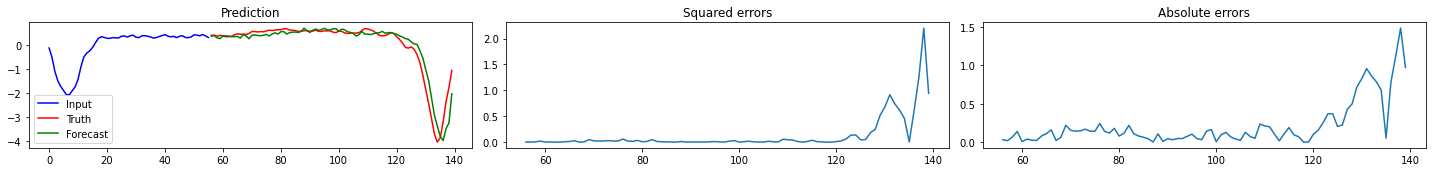

TDI: 0.15, TDM: -0.04 


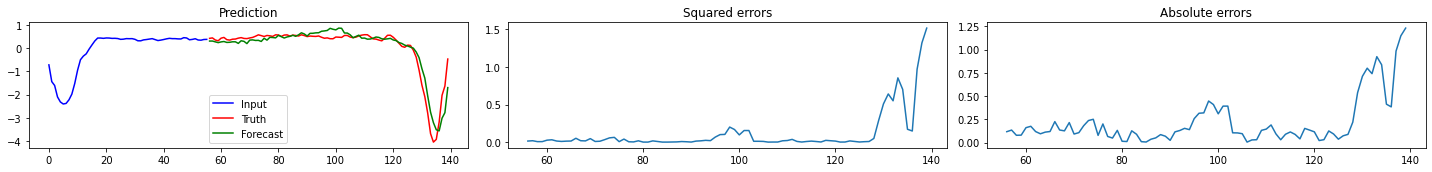

TDI: 0.18, TDM: -0.37 


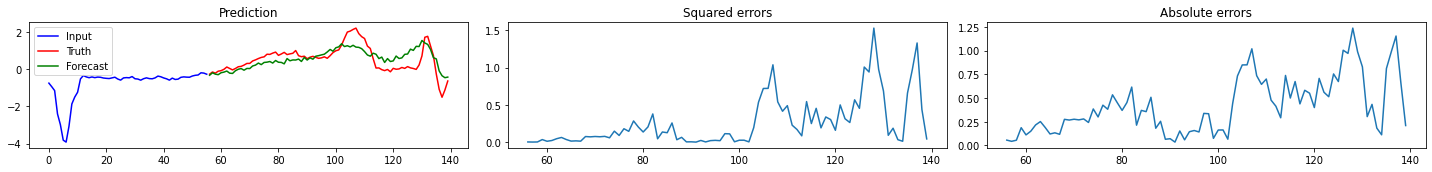

TDI: 0.14, TDM: 0.37 


In [5]:
# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

Evaluation of method 'Conv' on dataset 'ECG5000', a total of 4500 84-step forecasts.



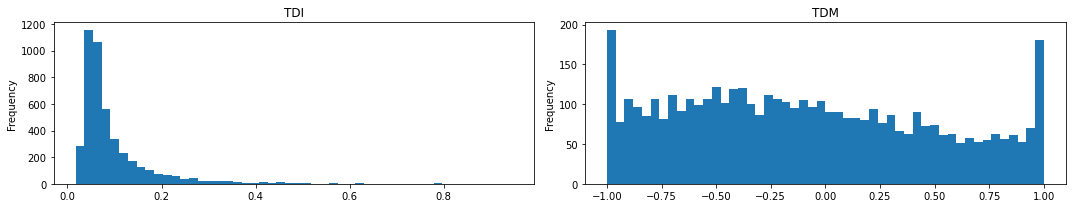

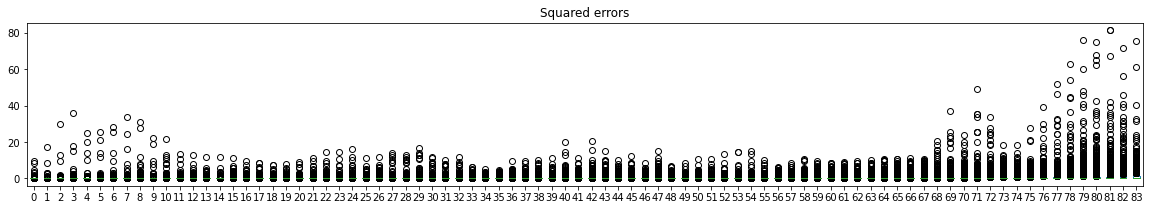

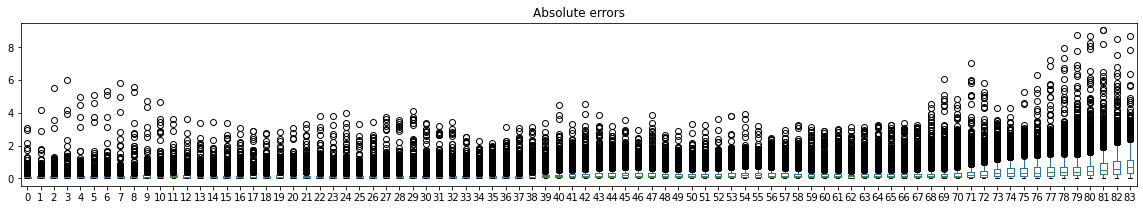

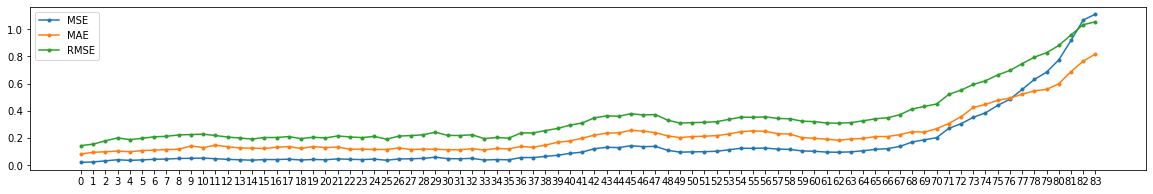

In [6]:
# Compute evaluation
res_ecg = Evaluation(y_test, yhat_test, "ECG5000", "Conv")
print(res_ecg)
res_ecg.plot()

# Dataset: Traffic

In [7]:
# Split a multivariate sequence into samples
def get_sequence_pairs(series, n_steps_in, n_steps_out):
    x, y = list(), list()
   
    for i in range(len(series)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(series):
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = series[i:end_ix], series[end_ix:out_end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [13]:
# Parameters
column = 0
window = 24
horizon = 24

# Load data
df = pd.read_csv("../data/mvdata/traffic.txt", usecols=[column], header=None)
train, test = train_test_split(df[0], test_size=0.2, shuffle=False)

x_train, y_train = get_sequence_pairs(train, window, horizon)
x_test, y_test = get_sequence_pairs(test, window, horizon)

# Build model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(np.expand_dims(x_train, axis=2), y_train, epochs=25, verbose=0)

# Forecasts
yhat_test = model.predict(np.expand_dims(x_test, axis=2), verbose=1) 

109/109 [==============================] - 0s 750us/step


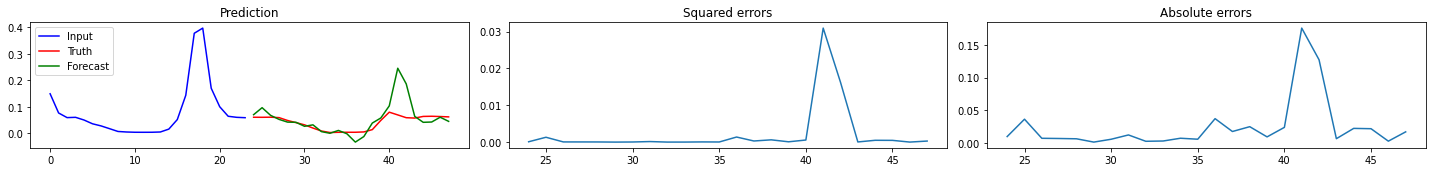

TDI: 0.05, TDM: 0.10 


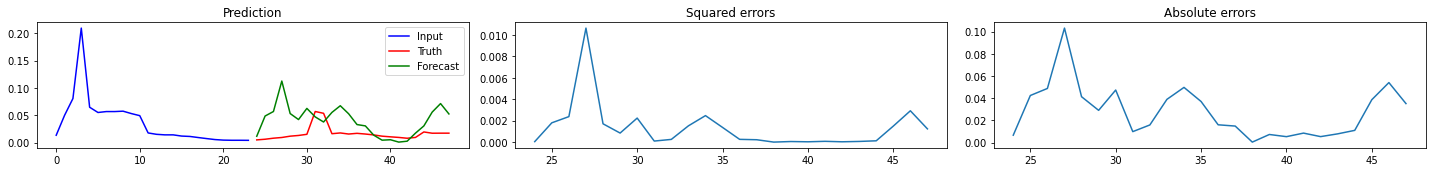

TDI: 0.17, TDM: -0.45 


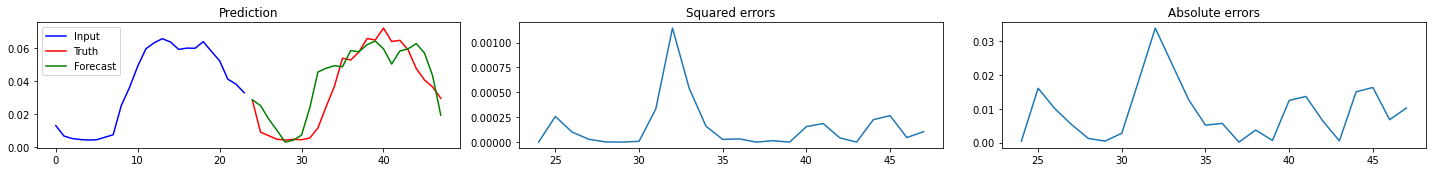

TDI: 0.10, TDM: -0.41 


In [14]:
# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

Evaluation of method 'Conv' on dataset 'ECG5000', a total of 4500 84-step forecasts.



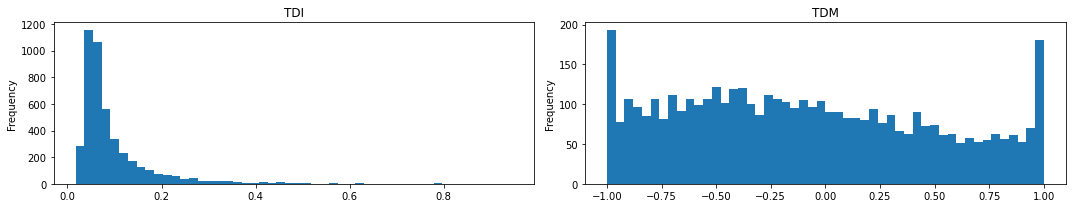

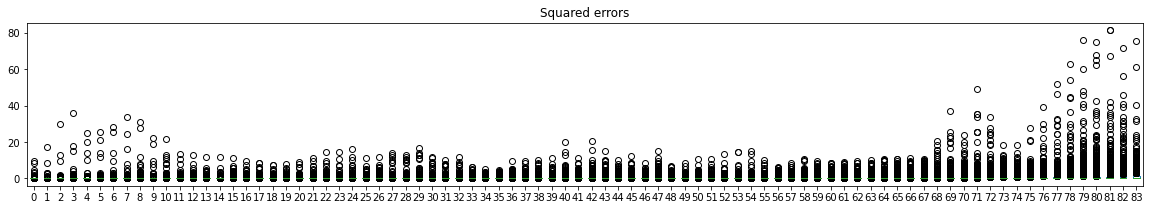

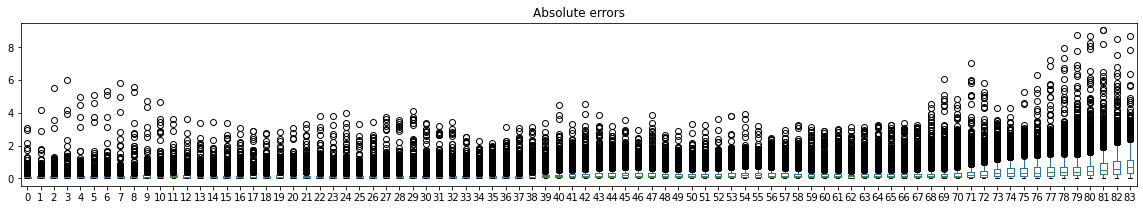

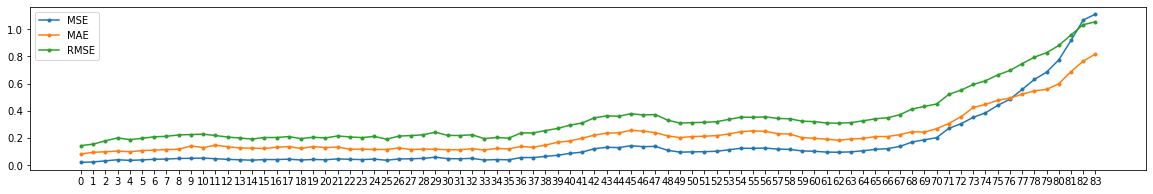

In [15]:
# Compute evaluation
res_traffic = Evaluation(y_test, yhat_test, "Traffic", "Conv")
print(res_ecg)
res_ecg.plot()